In [1]:
import numpy as np # Для работы с матрицами и векторами
import pandas as pd # Для удобного представления и работы с данными в формате DataFrame
import matplotlib.pyplot as plt # Построение и работа с графиками


from sklearn.preprocessing import MinMaxScaler # Для масштабирования спектров на интервал (0,1)
from sklearn.metrics import classification_report, roc_curve # Метрики качества классификации
from sklearn.metrics import mean_squared_error as MSE, r2_score # Метрика качества регрессии

#Classifiers
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#Regressoors
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition.pls_ import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


#PCA
from sklearn.decomposition import RandomizedPCA, PCA


#Train Test Split
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit # Для отложенной выборки и кросс-валидации

import statsmodels.api as sm # Для программного сглаживания шумов спектров
import seaborn as sns # Более навороченный построитель графиков, на всякий


from ipywidgets import interact, interact_manual # Для интерактивного изменения параметров моделей, графиков и прочего

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing

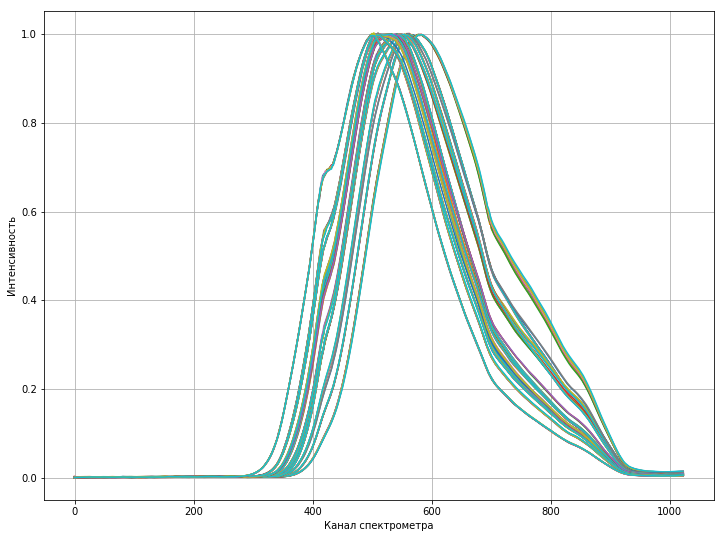

In [2]:
# Загрузили данные
Data = pd.read_csv('lowess_data_spectrum.csv', sep=',')
Data.drop(['Unnamed: 0', 'pH'], axis=1, inplace=True)

# Програмно сгладили шумы
data_lowess_1 = list()


plt.figure(figsize=(12,9))
plt.xlabel(u'Канал спектрометра')
plt.ylabel(u'Интенсивность')
plt.grid()
for i in range(Data.shape[0]) :
    x = range(Data.shape[1])
    y = Data.iloc[i].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.015)
    plt.plot(lowess[:,0], lowess[:,1]) # Рисовать график не хотим
    data_lowess_1.append(lowess[:,1])

lowess_df = pd.DataFrame(np.array(data_lowess_1))

# Нормируем по максимуму на (0,1)
scaler = MinMaxScaler()
scaler.fit(lowess_df.T)
scaled_lowess_df = pd.DataFrame(scaler.transform(lowess_df.T)).T

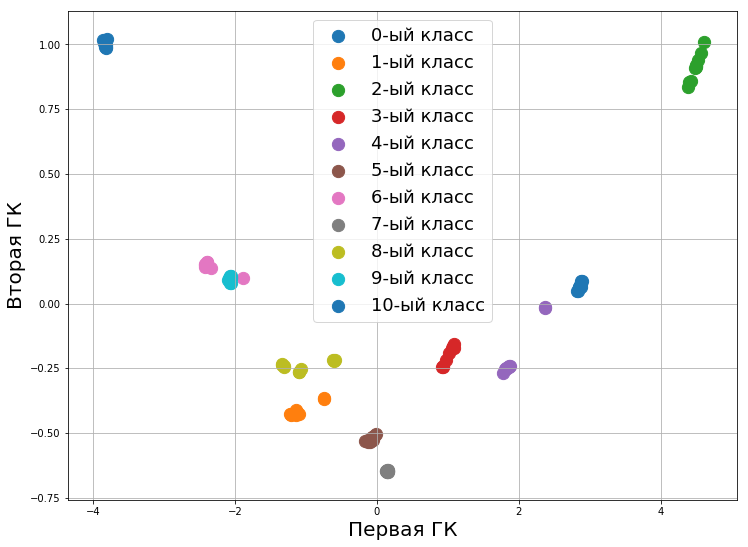

In [4]:
# PCA преобразование
pca_model = PCA(n_components=3)
pca_data = pd.DataFrame(pca_model.fit_transform(scaled_lowess_df))

# Добавим метку класса
target_label = np.array([0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10+[10]*10)
pca_data['target_label'] = target_label

# Построим график проекций на первые две ГК 
labels = pca_data.target_label.drop_duplicates().values

plt.figure(figsize=(12,9))
plt.xlabel(u'Первая ГК', fontsize=20)
plt.ylabel(u'Вторая ГК', fontsize=20)
for i in labels:
    plt.scatter(pca_data.iloc[i*10:i*10+10,0], pca_data.iloc[i*10:i*10+10,1], s=150, label=str(i)+u'-ый класс')
plt.legend(loc='upper center', fontsize=18)
plt.grid()

## Classification

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(pca_data.drop('target_label', axis=1),
                                                                   pca_data.target_label,
                                                                   test_size=0.3, stratify=pca_data.target_label,
                                                                    random_state=1515)

classifier = RandomForestClassifier() #KNeighborsClassifier(n_neighbors=2)
classifier.fit(train_data, train_labels)
preds = classifier.predict(test_data)

In [6]:
print classification_report(test_labels, preds)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00        33



## Regression

In [9]:
# Калибровка из номера канала в нм
chnl_to_nm = np.linspace(443.86,1007.41, 1024)

# Загружаем
Data_Dry = pd.read_csv('prep_data_20190318.csv', sep=',')
Data_SemiSweet = pd.read_csv('prep_data_20190319.csv', sep=',')
Data_SemiDry = pd.read_csv('prep_data_20190320.csv', sep=',')

Data_Dry.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiSweet.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiDry.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
# Объединяем
Data = pd.concat([Data_Dry, Data_SemiDry, Data_SemiSweet], axis=0)

In [11]:
# Сортируем по pH
Data.sort_values('pH', inplace=True)

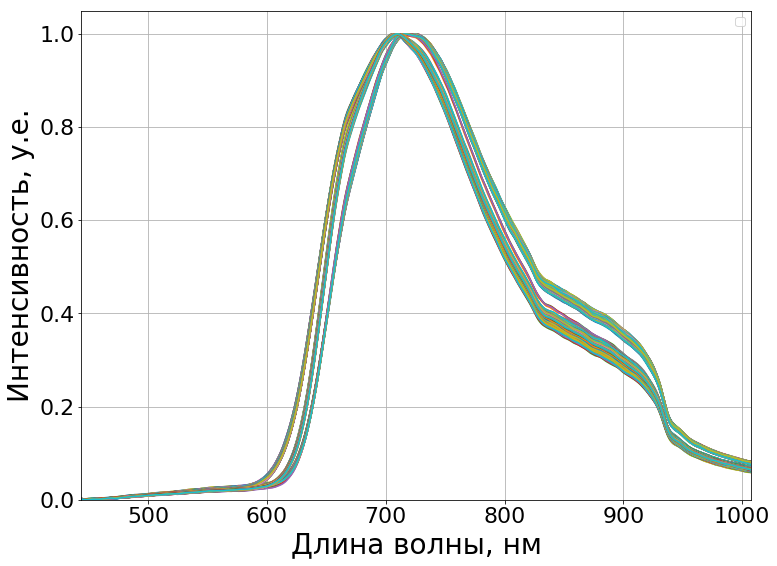

In [12]:
plt.figure(figsize=(12,9))
plt.grid(which=u'both')

for i in range(Data.shape[0]):
    plt.plot(chnl_to_nm , Data.iloc[i,:-1].values)

plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=28)
plt.ylabel(u'Интенсивность, у.е.', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=12)
#plt.savefig('ph_reg_scaled_spectra.pdf')

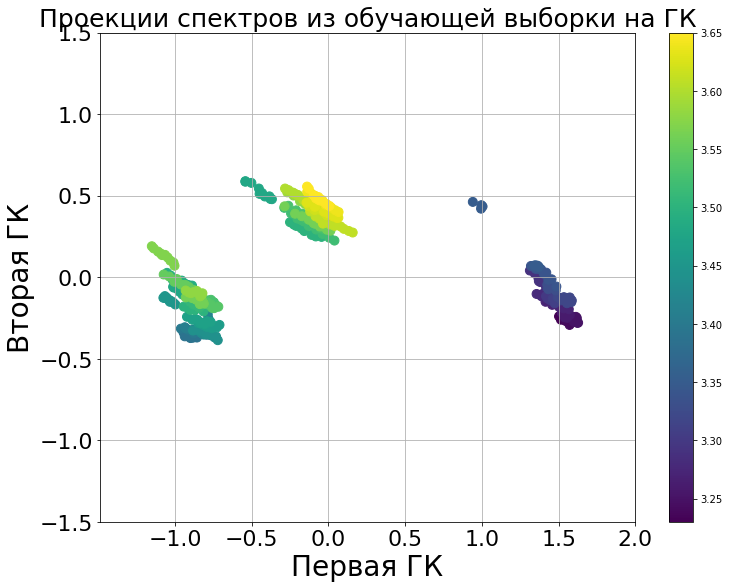

In [13]:
pca_model = PCA(n_components=3)
pca_model.fit(Data.drop('pH', axis=1))
PCA_Data = pd.DataFrame(pca_model.transform(Data.drop('pH', axis=1)))
PCA_Data['pH'] = Data.pH.values

plt.figure(figsize=(12,9))
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=80)


plt.title(u'Проекции спектров из обучающей выборки на ГК', fontsize=25)
plt.xlabel(u'Первая ГК', fontsize=28)
plt.ylabel(u'Вторая ГК', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlim(-1.49,2)
plt.ylim(-1.5,1.5)


####################################################################################################
# Добавляет фигуры очерчивающие кластеры точек
####################################################################################################

# plt.gca().add_patch(Circle((-0.20,0.4),0.4,linewidth=3,edgecolor='lightblue',facecolor='none'))
# plt.text(0.1,0,u'"Лази", Сухое', fontsize=16)

# plt.gca().add_patch(Circle((-0.90,-0.1),0.35,linewidth=3,edgecolor='lightgreen',facecolor='none'))
# plt.text(-0.7,-0.5,u'"Пиросмани", Полусухое', fontsize=16)

# plt.gca().add_patch(Ellipse((1.3,0), 0.45, 1.6, angle=45, linewidth=3,edgecolor='pink',facecolor='none'))
# plt.text(0.85,0.65,u'"Tamagne", Полусладкое', fontsize=16)

####################################################################################################

cb = plt.colorbar()

plt.grid()
#plt.savefig('ph_reg_pca_plot_train.pdf')

In [14]:
# Доля объясненной диперсии PCA :
for i, ratio in enumerate(pca_model.explained_variance_ratio_):
    print u'Доля дисперсии ', i, '-й компоненты : ', ratio.round(4)*100, '%'
print u'Объясненная доля дисперсии модели PCA : ', pca_model.explained_variance_ratio_.sum().round(4)*100,'%'

Доля дисперсии  0 -й компоненты :  91.93 %
Доля дисперсии  1 -й компоненты :  7.75 %
Доля дисперсии  2 -й компоненты :  0.19 %
Объясненная доля дисперсии модели PCA :  99.86 %


Среднеквадратичная ошибка :  0.0169


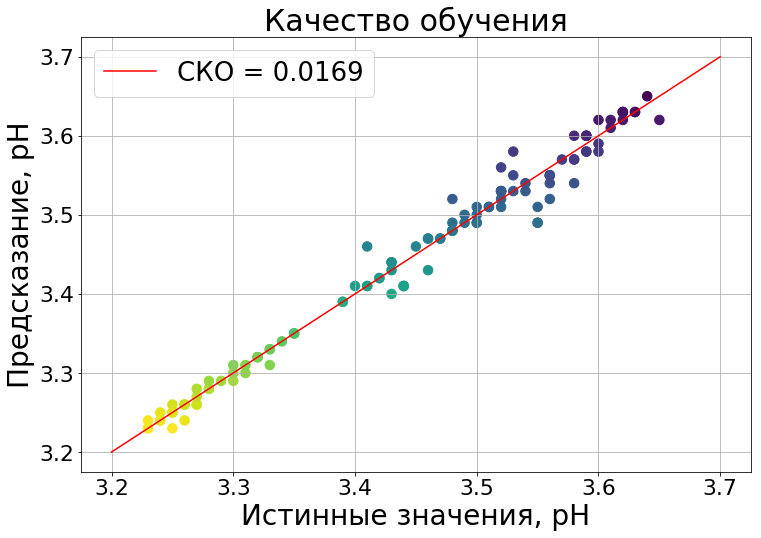

In [15]:
# Отложенная выборка : test_size - размер отложенной тестовой выборки,
#                      random_state - "фиксируем случайность" 
train_data, test_data, train_target, test_target = train_test_split(PCA_Data.drop('pH', axis=1),
                                                                    PCA_Data.pH,
                                                                   test_size=0.25, random_state=123)

# Выбираем модель : градиентного бустинга
regressor = GradientBoostingRegressor(learning_rate=0.08, n_estimators=200, max_depth=7)
# Обучаем
regressor.fit(train_data, train_target)
# Делаем предсказание
preds = regressor.predict(test_data)
 

print u'Среднеквадратичная ошибка : ', np.sqrt(MSE(test_target.values, preds)).round(4)

plt.figure(figsize=(12,8))
plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1), c='r', label=u'СКО = '+str(np.sqrt(MSE(test_target.values, preds)).round(4)))
plt.scatter(test_target.values, preds.round(2),  c=1-(preds-preds.min())/preds.max(), s=90)
plt.xlabel(u'Истинные значения, pH', fontsize=28)
plt.ylabel(u'Предсказание, pH', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title(u'Качество обучения', fontsize=30)
plt.legend(fontsize=26)
plt.grid()
#plt.savefig('ph_reg_train_res.pdf')

In [16]:
regressors = []
mse_array = []
scores = []
for i in range(100):
    train_data, test_data, train_target, test_target = train_test_split(PCA_Data.drop('pH', axis=1),
                                                                        PCA_Data.pH,
                                                                        test_size=0.25, random_state=i)

    
    regressor = GradientBoostingRegressor(loss='lad', learning_rate=0.08, n_estimators=200,
                                          max_depth=7, random_state=i, criterion='mse', subsample=0.75)
    regressor.fit(train_data, train_target)
    preds = regressor.predict(test_data)
    
    regressors.append(regressor)
    mse_array.append(MSE(test_target.values, preds.round(2)))
    scores.append(regressor.score(test_data, test_target))

In [17]:
print 'MSE : ', mse_array[:20]
print 
print 'Corrs : ', scores[:20]
print 
print 'Среднее MSE по 100 случайным выборкам : ', np.sqrt(np.mean(mse_array)).round(4)
print 'Средняя корреляция по 100 случайным выборкам : ', np.mean(scores).round(4)

MSE :  [0.00029304347826086916, 0.00020782608695652148, 0.00020086956521739145, 0.0002052173913043472, 0.00024173913043478172, 0.0003086956521739132, 0.00027043478260869514, 0.0002234782608695645, 0.00030782608695652084, 0.00026347826086956444, 0.00028173913043478155, 0.0002904347826086953, 0.0001869565217391303, 0.00026347826086956563, 0.0002939130434782609, 0.0002930434782608692, 0.00017043478260869534, 0.00022521739130434838, 0.00026086956521739106, 0.0003617391304347809]

Corrs :  [0.9816779762388225, 0.985904464543623, 0.9867482617457811, 0.9849311455564094, 0.9860202863979237, 0.9791491935693826, 0.9809199995525227, 0.9862231152084174, 0.9801814550773918, 0.9852772555380357, 0.9792667115751156, 0.978556655092004, 0.9886694326204917, 0.9832802747121281, 0.9813701697424093, 0.9828170249929183, 0.9880781769331547, 0.9861138767204797, 0.9840427297902533, 0.9771358083636835]

Среднее MSE по 100 случайным выборкам :  0.0155
Средняя корреляция по 100 случайным выборкам :  0.9843


In [19]:
#########################################################################################################
                                ### Загрузим тестовые данные ###
#########################################################################################################

Testing_Data = pd.read_csv('Test_for_model_21_03.txt', sep=' ')
Testing_Data.drop(['Channel', 'Wavelength(nm)', 'Current', 'BackGround', 'Unnamed: 44'], axis=1, inplace=True)
Testing_Data = Testing_Data.iloc[:1024,:].T
Testing_Data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Spectrum1,20,35,25,22,27,14,31,20,16,30,...,1101,1102,1071,1077,1088,1103,1063,1058,1086,1056
Spectrum2,0,26,22,16,18,12,26,29,-13,22,...,1066,1068,1064,1065,1039,1078,1057,1068,1018,1012
Spectrum3,7,5,19,-11,15,7,40,27,50,26,...,1028,1041,1026,1033,1051,1026,1031,1014,1046,985
Spectrum4,41,30,25,11,27,5,30,9,38,30,...,1019,1032,1014,1026,1003,1004,990,993,1005,1009
Spectrum5,-3,30,6,48,42,29,22,30,12,15,...,992,993,986,996,994,997,987,982,1005,977
Spectrum6,15,5,28,26,17,25,-10,30,9,42,...,999,957,971,975,1000,993,950,957,960,971
Spectrum7,28,0,3,20,36,18,19,19,27,66,...,982,932,959,986,937,972,942,937,961,932
Spectrum8,13,31,19,-2,0,-3,12,15,45,8,...,942,947,941,963,970,961,905,948,917,907
Spectrum9,5,-4,21,16,28,-7,-7,24,24,37,...,947,948,939,939,955,938,891,892,920,917
Spectrum10,31,13,39,30,15,-10,47,38,30,37,...,1044,1063,1027,1028,1056,1047,1011,1031,1019,999


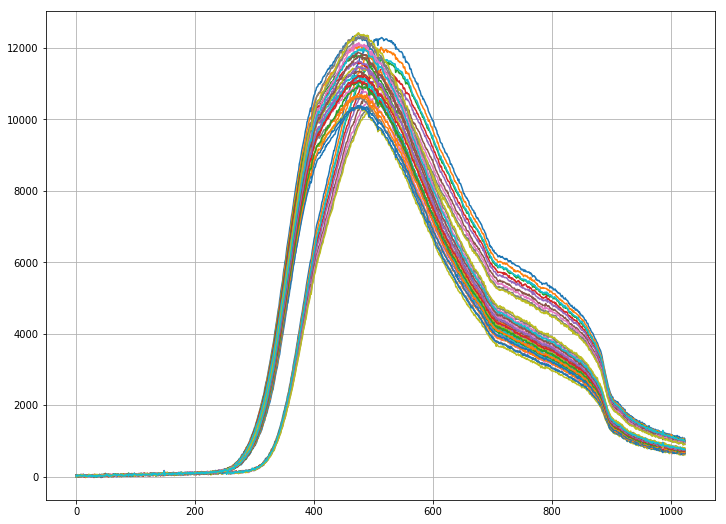

In [20]:
# Первая строка датафрейма почему то состоит из строк -- исправим
Testing_Data.iloc[0,:] = map(lambda x: float(x), Testing_Data.iloc[0,:].values)

plt.figure(figsize=(12,9))
for i in range(40):
    plt.plot(range(1024) ,Testing_Data.iloc[i,:].values)
plt.grid()

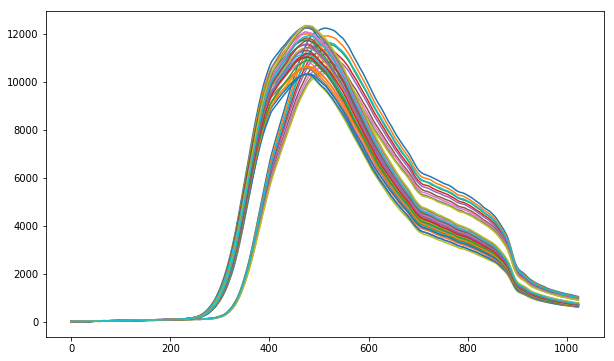

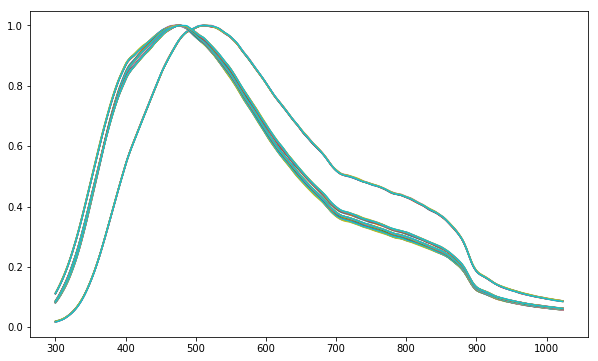

In [21]:
data_lowess_1 = list()
plt.figure(figsize=(10,6))
for i in range(Testing_Data.shape[0]) :
    x = range(Testing_Data.shape[1])
    y = Testing_Data.iloc[i,:].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.015)
    plt.plot(lowess[:,0], lowess[:,1])
    data_lowess_1.append(lowess[:,1])

lowess_Testing_Data = pd.DataFrame(np.array(data_lowess_1))

scaler = MinMaxScaler()
scaler.fit(lowess_Testing_Data.T)
lowess_Testing_Data = pd.DataFrame(scaler.transform(lowess_Testing_Data.T)).T

plt.figure(figsize=(10,6))
for i in range(40):
    plt.plot(range(300,1024) ,lowess_Testing_Data.iloc[i,300:].values)

In [22]:
# Добавим целевое (восстанавливаемое) значение pH
pH = np.array([3.38]*10+[3.21]*10+[3.75]*10+[3.58]*10)
lowess_Testing_Data['pH'] = pH

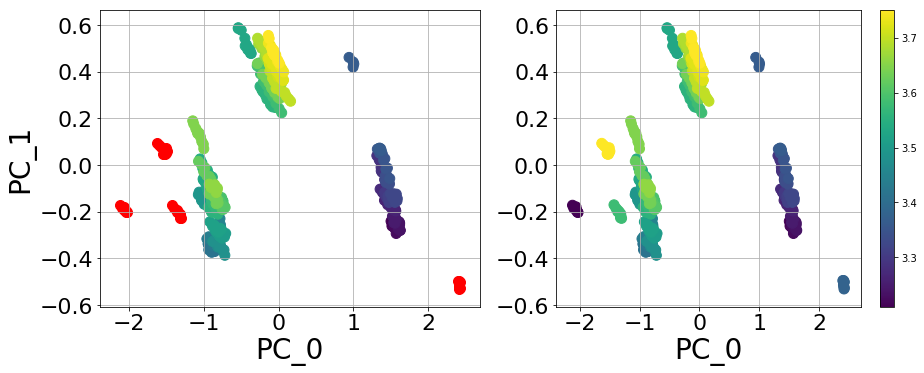

In [23]:
################################################################################################################
                            ### Спроецируем спектры тестовой выборки на ГК обучающей ###
################################################################################################################


PCA_Testing_Data = pd.DataFrame(pca_model.transform(lowess_Testing_Data.drop('pH', axis=1)))
PCA_Testing_Data['pH'] = lowess_Testing_Data.pH.values


plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=100)
plt.scatter(PCA_Testing_Data.iloc[:,0], PCA_Testing_Data.iloc[:,1], c='r', s=100)

plt.xlabel('PC_0', fontsize=28)
plt.ylabel('PC_1', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.grid()

plt.subplot(2,2,2)
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=100)
plt.scatter(PCA_Testing_Data.iloc[:,0], PCA_Testing_Data.iloc[:,1], c=PCA_Testing_Data.pH.values[:], s=100)
#plt.gca().add_patch(Circle((-2.06,-0.19),0.13,linewidth=2,edgecolor='r',facecolor='none'))
#plt.text(-2.2,-0.45,u'№1', fontsize=25)
plt.grid()


#plt.title(u'Проекции спектров из обучающей выборки на ГК', fontsize=26)
plt.xlabel('PC_0', fontsize=28)
#plt.ylabel('PC_1', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.colorbar()

#plt.savefig('ph_reg_pca_plot_test.pdf')

plt.show()

In [24]:
# Сделаем усредненное предсказание
Predictions = []
for reg in regressors:
    Predictions.append(reg.predict(PCA_Testing_Data.drop('pH', axis=1)))
Predictions = np.array(Predictions)

Prediction = Predictions.mean(axis=0)

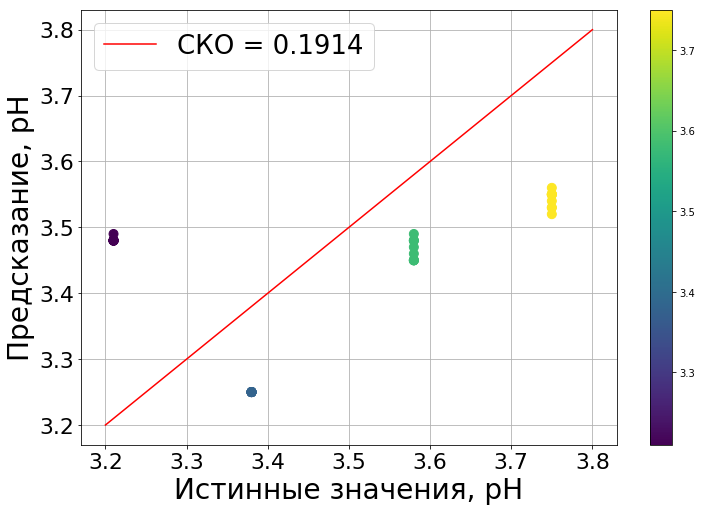

Среднеквадратичная ошибка :  0.1914
Коэффициент детерминации :  0.116


In [25]:
plt.figure(figsize=(12,8))

plt.plot(np.arange(3.2,3.9,0.1), np.arange(3.2,3.9,0.1), c='r', label=u'СКО = '+str(np.sqrt(MSE(Prediction, PCA_Testing_Data.pH.values)).round(4)))
#plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1)+0.18, c='orange', linestyle='dashed')

plt.scatter(PCA_Testing_Data.pH.values, Prediction.round(2), c=PCA_Testing_Data.pH.values, s=80)
plt.xlabel(u'Истинные значения, pH',  fontsize=28)
plt.ylabel(u'Предсказание, pH', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.title(u'Качество регрессии', fontsize=30)


# plt.gca().add_patch(Rectangle((3.2,3.47),0.02,0.03,linewidth=3,edgecolor='r',facecolor='none'))
# plt.text(3.21,3.51,u'№2', fontsize=18) #Таманский погреб

# plt.gca().add_patch(Circle((3.38,3.25),0.015,linewidth=3,edgecolor='pink',facecolor='none'))
# plt.text(3.40,3.27,u'№1', fontsize=18) #Tamai, "Cabernet"

# plt.gca().add_patch(Ellipse((3.58,3.47),0.03,0.06,linewidth=3,edgecolor='lightblue',facecolor='none'))
# plt.text(3.59,3.51,u'№4', fontsize=18) #"Carbieres"

# plt.gca().add_patch(Ellipse((3.75,3.54),0.03,0.06,linewidth=3,edgecolor='lightblue',facecolor='none'))
# plt.text(3.76,3.575,u'№3', fontsize=18) #"Саперави"


plt.legend(fontsize=26)
plt.grid()
plt.savefig('ph_reg_test_res.pdf')
plt.colorbar()
plt.show()
print u'Среднеквадратичная ошибка : ', np.sqrt(MSE(Prediction, PCA_Testing_Data.pH.values)).round(4)
print u'Коэффициент детерминации : ', r2_score(PCA_Testing_Data.pH.values, Prediction,).round(3)